This notebook features EDA on the AIM 1994 Diabetes Dataset.        
      data-[01-70]: data sets covering several weeks' to months' worth of
outpatient care on 70 patients.       
Diabetes files consist of four fields per record.  Each field is
separated by a tab and each record is separated by a newline.   

File Names and format:       
(1) Date in MM-DD-YYYY format     
(2) Time in XX:YY format    
(3) Code     
(4) Value    

Importing libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tarfile 
import matplotlib.pyplot as plt
import warnings
import scipy
import seaborn as sns
%matplotlib inline

The source is a .zip file, we will extract and store all respective files in our working directory.
Since the data belongs to 70 difference outpatients, it is not wise to create a single unified dataframe for exploration.
We can load each file using pd.to_csv and iterate a For loop and store the separate tables in a list.

In [ ]:
!tar -xvf "C:\Users\FeedSpot.DESKTOP-IQ6759U\Downloads\diabetesdataset\diabetes-data.tar.Z"

In [2]:
filepath = "Diabetes-Data"

In [3]:
df_list = []
for i in range(1, 71):  
    file_name = f"Diabetes-Data/data-{i:02d}"
    df = pd.read_csv(
        file_name,
        delimiter="\t",            # tab-separated
        header=None,              
        names=["Date", "Time", "Code", "Value"]
    )
    df['id']=f"{i:02d}"
    df_list.append(df)

Great, now we can access any patient's data by indexing the list

In [172]:
df_list[0].head(6) #data of patient no.1, confirmed by the id column

,Date,Time,Code,Value,id
0,04-21-1991,9:09,58,100,01
1,04-21-1991,9:09,33,9,01
2,04-21-1991,9:09,34,13,01
3,04-21-1991,17:08,62,119,01
4,04-21-1991,17:08,33,7,01
5,04-21-1991,22:51,48,123,01


In [ ]:
#merged_df = pd.concat(df_list, axis=0, ignore_index=True)
#creating a merged dataframe in case i need it later

For now, we will only explore blood glucose trends of patient id=1. If done successfully, it can be re-iterated for other patients

In [4]:
df1 = df_list[0]

In [5]:
len(df1['Value'].isnull())  

943

Our aim is to check time series of Blood Glucose values for the patient. So we will only use those rows whose 'Code' feature pertains to glucose measurements

48 = Unspecified blood glucose measurement     
57 = Unspecified blood glucose measurement  
58 = Pre-breakfast blood glucose measurement            
59 = Post-breakfast blood glucose measurement    
60 = Pre-lunch blood glucose measurement   
61 = Post-lunch blood glucose measurement   
62 = Pre-supper blood glucose measurement   
63 = Post-supper blood glucose measurement    
64 = Pre-snack blood glucose measurement    
65 = Hypoglycemic symptoms      
Lets create a copy

In [ ]:
df1.loc[df1['Code'].isin([65, 66, 67, 68, 69, 70, 71, 72]), 'Value'].head()

In [51]:
df_bloodglucose = df1[(df1['Code']>47) & (df1['Code']<65)].copy()

In [52]:
df_bloodglucose.shape

(369, 5)

In [53]:
df_bloodglucose['datetime'] = pd.to_datetime(df_bloodglucose['Date'] + ' ' + df_bloodglucose['Time'])

In [9]:
df_bloodglucose.head()

,Date,Time,Code,Value,id,datetime
0,04-21-1991,9:09,58,100,01,1991-04-21 09:09:00
3,04-21-1991,17:08,62,119,01,1991-04-21 17:08:00
5,04-21-1991,22:51,48,123,01,1991-04-21 22:51:00
6,04-22-1991,7:35,58,216,01,1991-04-22 07:35:00
10,04-22-1991,16:56,62,211,01,1991-04-22 16:56:00


In [54]:
df_bloodglucose = df_bloodglucose.drop(['Date', 'Time'], axis=1)
df_bloodglucose.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 940
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Code      369 non-null    int64         
 1   Value     369 non-null    int64         
 2   id        369 non-null    object        
 3   datetime  369 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 14.4+ KB


In [55]:
df_bloodglucose['datetime'].max() - df_bloodglucose['datetime'].min()

Timedelta('134 days 22:11:00')

In [56]:
df_bloodglucose = df_bloodglucose.sort_values('datetime')

In [57]:
import matplotlib.pyplot as plt
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

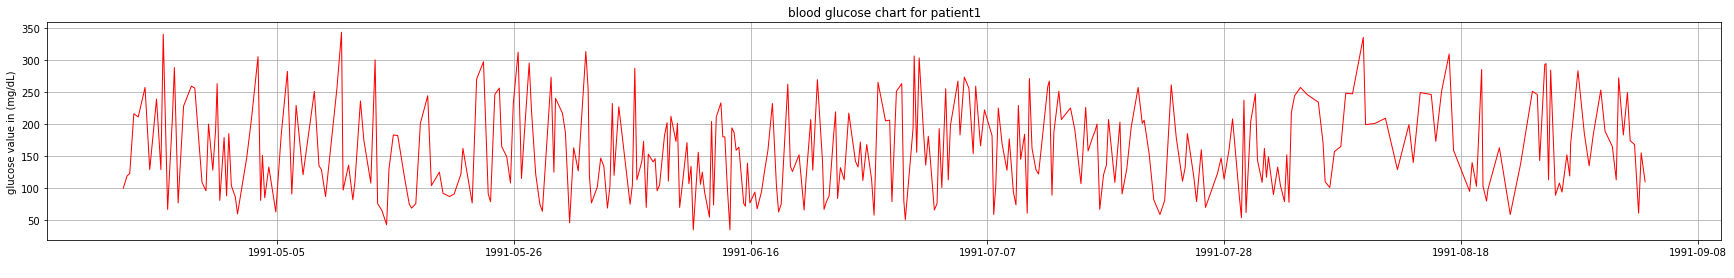

In [14]:
plt.figure(figsize=(30,4))
plt.plot(df_bloodglucose['datetime'].values,df_bloodglucose['Value'].values, color='red', linewidth=1)
plt.title('blood glucose chart for patient1')
plt.xlabel(" ")
plt.ylabel("glucose value in (mg/dL)")
plt.grid(True)
plt.savefig("blood_glucose_trend.png", dpi=300, bbox_inches='tight')
plt.show()

Although there exists a specific code '65' for hypoglycemic symptoms in the data, the value for that code drops to zero and hence thats not much useful to us. Instead we will arbitrarily set a cutoff of blood glucose (<55 mg/dl) as an alert point for an hypoglycemic symptom event.
Not only that, we will also set 200 as the trigger for an hyperglycemic event

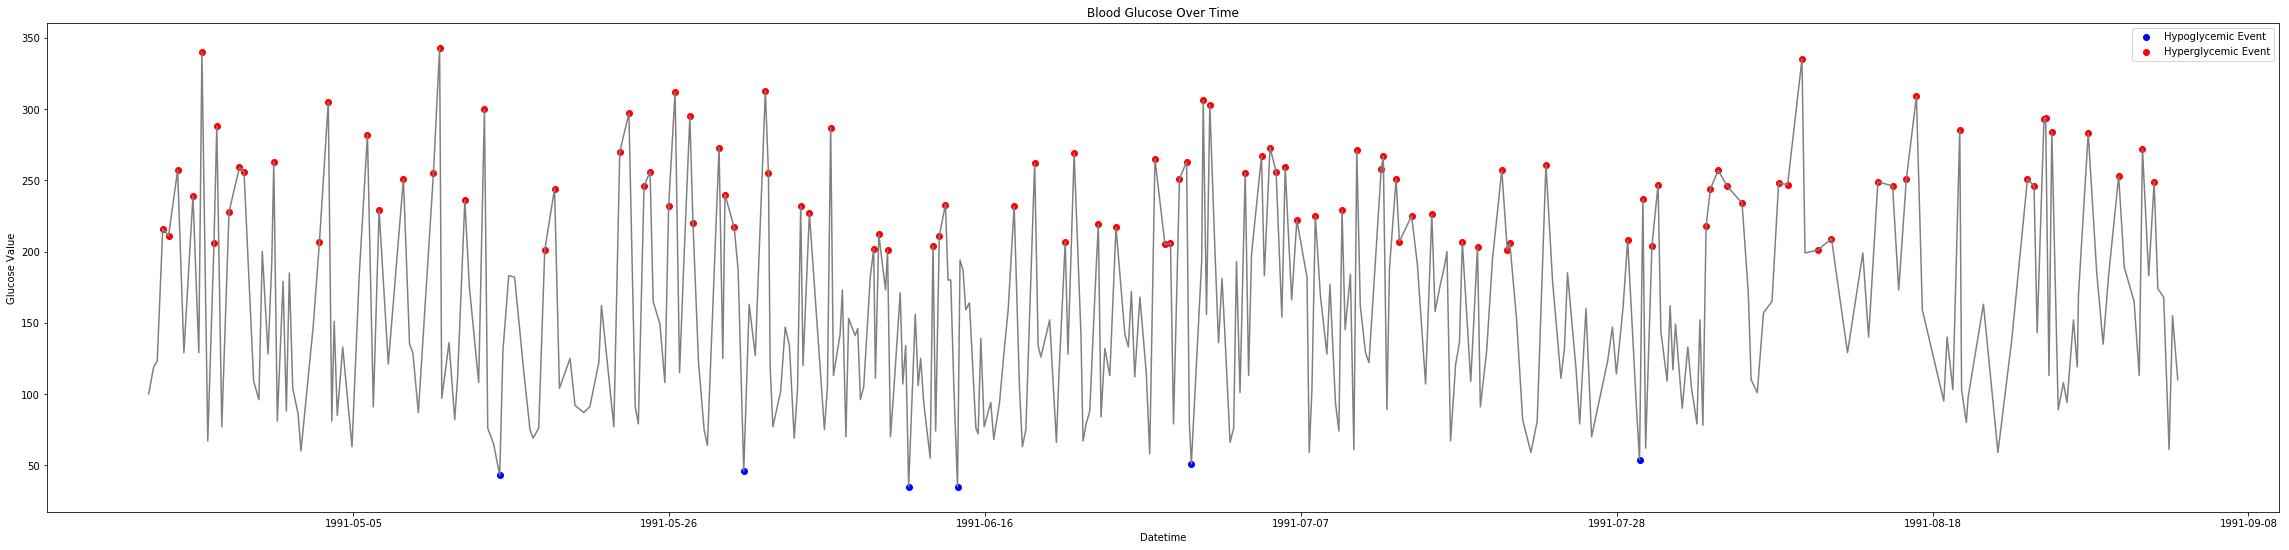

In [63]:
plt.figure(figsize=(40,9))
plt.plot(df_bloodglucose['datetime'].values, df_bloodglucose['Value'].values, color='grey', linewidth=1.5)


hypo = df_bloodglucose[df_bloodglucose['Value'] < 55] 
hyper = df_bloodglucose[df_bloodglucose['Value'] > 200] 
plt.scatter(hypo['datetime'], hypo['Value'], color='blue', label='Hypoglycemic Event')
plt.scatter(hyper['datetime'], hyper['Value'], color='red', label='Hyperglycemic Event')

plt.legend()
plt.title('Blood Glucose Over Time')
plt.xlabel('Datetime')
plt.ylabel('Glucose Value')
plt.show()

In [16]:
df_bloodglucose = df_bloodglucose.set_index('datetime')
df_bloodglucose = df_bloodglucose.sort_index()

In [17]:
x = (df_bloodglucose.index - df_bloodglucose.index[0]).days.values
y = df_bloodglucose['Value'].values

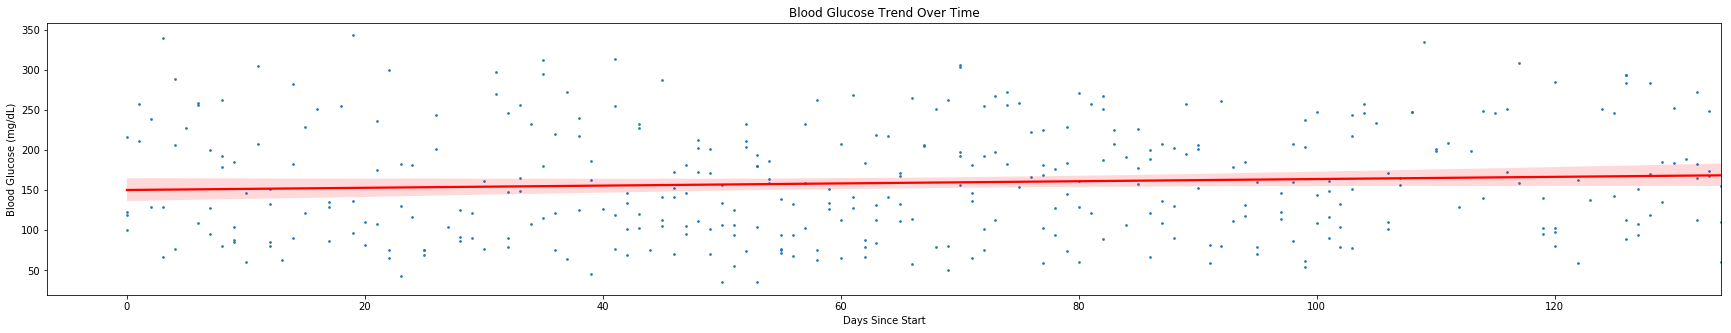

In [18]:
plt.figure(figsize=(30,5))
sns.regplot(x=x, y=y, scatter_kws={'s':3, 'alpha':0.9}, line_kws={'color':'red'})
plt.title("Blood Glucose Trend Over Time")
plt.xlabel("Days Since Start")
plt.ylabel("Blood Glucose (mg/dL)")
plt.show()

In [19]:
slope, intercept = np.polyfit(x, y, 1)
mean = df_bloodglucose['Value'].mean()
print("Slope:", slope )
print("Mean BG for Patient 1:", mean)
if slope > 0.2:
    print ("glucose levels rising, Patient needs attention")
else :
    print ("glucose levels are stable-")
if mean > 150:
    print ("but high, poorly controlled diabetes")

Slope: 0.13648827164496205
Mean BG for Patient 1: 159.0460704607046
glucose levels are stable-
but high, poorly controlled diabetes


Since the average BG doesnt change a lot. We can see the best fit line is mostly flat and hence not much useful.     
Let's observe finer trends using a smoother curve

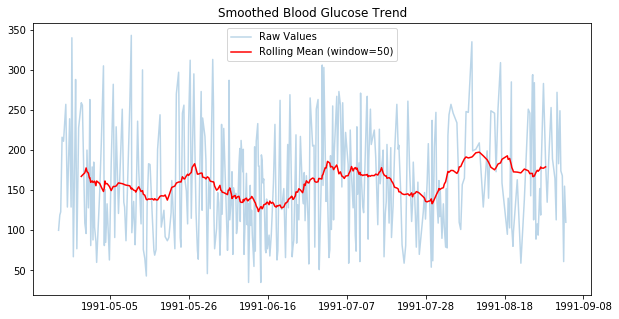

In [20]:
df_bloodglucose['rolling_mean'] = df_bloodglucose['Value'].rolling(window=30, center=True).mean()

plt.figure(figsize=(10,5))
plt.plot(df_bloodglucose['Value'], alpha=0.3, label='Raw Values')
plt.plot(df_bloodglucose['rolling_mean'], color='red', label='Rolling Mean (window=50)')
plt.title("Smoothed Blood Glucose Trend")
plt.legend()
plt.show()

One can clearly notice the mean fluctuates between 150 and 200, very high values for BG concentration

We have explored Patient 01's data and discovered some insights. Now we need to do it for all 70. This we can do by writing 
a function containing all the above commands and reiterating it through a loop from 1 till 70

In [100]:
from sklearn.linear_model import LinearRegression

def Patient_BG_report(df):
    """
    Analyze a single patient's glucose data.
      - Filtering blood glucose measurements
      - Combining date/time into datetime
      - Linear regression on glucose trend
      - Summary interpretation prints
    """

    # filtering bg measuremnts codes
    df_bg = df[(df['Code'] > 47) & (df['Code'] < 65)].copy()

    if df_bg.empty:
        print("No glucose records found for this patient.")
        return None
    
   #handling string values 
    df_bg['Value'] = df_bg['Value'].replace({'0Hi': '400', '0Lo': '40'})
    df_bg['Value'] = pd.to_numeric(df_bg['Value'], errors='coerce')
    df_bg = df_bg.dropna(subset=['Value'])
    df_bg['Value'] = df_bg['Value'].astype('int64')


    df_bg['Date'] = df_bg['Date'].astype(str).str.strip()
    df_bg['Time'] = df_bg['Time'].astype(str).str.strip()

# Combine and standardize format
    df_bg['datetime_str'] = df_bg['Date'] + ' ' + df_bg['Time']
    df_bg['datetime'] = pd.to_datetime(df_bg['datetime_str'], format='%m-%d-%Y %H:%M', errors='coerce')
    

    df_bg = df_bg.dropna(subset=['datetime']).sort_values('datetime')

    # setting days to zero
    df_bg['days_since_start'] = (df_bg['datetime'] - df_bg['datetime'].min()).dt.days
    x = df_bg['days_since_start'].values.reshape(-1, 1)
    y = df_bg['Value'].values

    # Caluculating slope
    if len(df_bg) > 1:
        model = LinearRegression().fit(x, y)
        slope = model.coef_[0]
    else:
        slope = np.nan

    # mean and standard deviation
    mean_glucose = y.mean()
    std_glucose = y.std()
    pid = df['id'].iloc[0] if 'id' in df.columns else "Unknown"

    # Print Results
    print(f"\n--- Patient {pid} Glucose Report ---")
    print(f"Records: {len(df_bg)}")
    print(f"Mean BG: {mean_glucose:.2f} mg/dL")
    print(f"Slope: {slope:.4f} mg/dL/day")
    print(f"Std Dev: {std_glucose:.2f}")

    if slope > 0.2:
        print("→ Glucose levels rising: patient may need attention.")


    if mean_glucose > 200:
        print("EXTREMELY HIGH Glucose. Need intervention")
    elif 200 > mean_glucose > 150:
        print("→ High mean glucose — poorly controlled diabetes.")
    elif mean_glucose < 70:
        print("→ Mean glucose too low — risk of hypoglycemia.")
    else:
        print("→ Mean glucose within acceptable range.")

    return { "id": pid, 
             "Records":len(df_bg),
             "Mean BG": round(mean_glucose, 2),
             "Slope": round(slope, 4),
             "Std Dev": round(std_glucose, 2) }

In [101]:
#Let's try a sample
df2 =  df_list[1]

In [23]:
df2.dtypes

Date     object
Time     object
Code      int64
Value    object
id       object
dtype: object

When we ran Patient_BG_report(df2) initially, we got an error and discovered that the 'Value' column was not numeric
and contained '0Hi' and '0Lo' string values. Our function was corrected and rewritten later to incorporate
the non-numeric values across data.         However below you will still find the 'manual' fix 
done to replace values using a dictionary

In [25]:
(df2['Value'] == '0Hi').sum()

6

In [ ]:
df2['Value'] = df2['Value'].replace({'0Hi': '400', '0Lo': '40'})

In [102]:
Patient_BG_report(df2)


--- Patient 02 Glucose Report ---
Records: 380
Mean BG: 197.01 mg/dL
Slope: -0.1715 mg/dL/day
Std Dev: 79.24
→ High mean glucose — poorly controlled diabetes.


{'id': '02',
 'Records': 380,
 'Mean BG': 197.01,
 'Slope': -0.1715,
 'Std Dev': 79.24}

In [64]:
#Lets try another sample
df6 =  df_list[5]

In [111]:
Patient_BG_report(df6)


--- Patient 06 Glucose Report ---
Records: 65
Mean BG: 200.74 mg/dL
Slope: 0.0923 mg/dL/day
Std Dev: 60.51
EXTREMELY HIGH Glucose. Need intervention


{'id': '06',
 'Records': 65,
 'Mean BG': 200.74,
 'Slope': 0.0923,
 'Std Dev': 60.51}

In [ ]:
#It works!

Now let's create a loop to run our function over and over to generate the blood glucose analysis and trend reports
for all 70 patients

In [103]:
results = []  

for i, df in enumerate(df_list, start=1):
    print(f"\nProcessing Patient {i:02d}...")
    result = Patient_BG_report(df) 
    if result is not None:
            results.append(result)
        
        
        



Processing Patient 01...

--- Patient 01 Glucose Report ---
Records: 369
Mean BG: 159.05 mg/dL
Slope: 0.1365 mg/dL/day
Std Dev: 69.26
→ High mean glucose — poorly controlled diabetes.

Processing Patient 02...

--- Patient 02 Glucose Report ---
Records: 380
Mean BG: 197.01 mg/dL
Slope: -0.1715 mg/dL/day
Std Dev: 79.24
→ High mean glucose — poorly controlled diabetes.

Processing Patient 03...

--- Patient 03 Glucose Report ---
Records: 149
Mean BG: 135.37 mg/dL
Slope: 0.4683 mg/dL/day
Std Dev: 64.38
→ Glucose levels rising: patient may need attention.
→ Mean glucose within acceptable range.

Processing Patient 04...

--- Patient 04 Glucose Report ---
Records: 147
Mean BG: 162.56 mg/dL
Slope: 0.7356 mg/dL/day
Std Dev: 78.46
→ Glucose levels rising: patient may need attention.
→ High mean glucose — poorly controlled diabetes.

Processing Patient 05...

--- Patient 05 Glucose Report ---
Records: 150
Mean BG: 167.77 mg/dL
Slope: 0.2720 mg/dL/day
Std Dev: 78.47
→ Glucose levels rising: pat


--- Patient 60 Glucose Report ---
Records: 112
Mean BG: 133.05 mg/dL
Slope: 1.5925 mg/dL/day
Std Dev: 77.14
→ Glucose levels rising: patient may need attention.
→ Mean glucose within acceptable range.

Processing Patient 61...

--- Patient 61 Glucose Report ---
Records: 120
Mean BG: 201.47 mg/dL
Slope: 0.8051 mg/dL/day
Std Dev: 112.21
→ Glucose levels rising: patient may need attention.
EXTREMELY HIGH Glucose. Need intervention

Processing Patient 62...

--- Patient 62 Glucose Report ---
Records: 132
Mean BG: 201.55 mg/dL
Slope: -0.8871 mg/dL/day
Std Dev: 109.04
EXTREMELY HIGH Glucose. Need intervention

Processing Patient 63...

--- Patient 63 Glucose Report ---
Records: 138
Mean BG: 197.58 mg/dL
Slope: -0.2247 mg/dL/day
Std Dev: 106.87
→ High mean glucose — poorly controlled diabetes.

Processing Patient 64...

--- Patient 64 Glucose Report ---
Records: 82
Mean BG: 121.67 mg/dL
Slope: -1.4230 mg/dL/day
Std Dev: 69.62
→ Mean glucose within acceptable range.

Processing Patient 65...


In [105]:
#Let's summarize the patient's bg data in a single data frame
summary_df = pd.DataFrame(results)

In [106]:
summary_df.head(6)

,id,Records,Mean BG,Slope,Std Dev
0,01,369,159.05,0.1365,69.26
1,02,380,197.01,-0.1715,79.24
2,03,149,135.37,0.4683,64.38
3,04,147,162.56,0.7356,78.46
4,05,150,167.77,0.2720,78.47
5,06,65,200.74,0.0923,60.51


So far, we have managed to analyse and club together all the patients' bg data togther numerically. The dataframe summary_df does not help us visualize how the bg line moves though.
###Let's write another function to generate a patient's blood glucose plot. we will also annotate hypoglycemic symptoms.

In [114]:
def Blood_Glucose_Chart(df):

    df_bg = df[(df['Code'] > 47) & (df['Code'] < 65)].copy()

    if df_bg.empty:
        print("No glucose records found for this patient.")
        return None
    
   #handling string values 
    df_bg['Value'] = df_bg['Value'].replace({'0Hi': '400', '0Lo': '40'})
    df_bg['Value'] = pd.to_numeric(df_bg['Value'], errors='coerce')
    df_bg = df_bg.dropna(subset=['Value'])
    df_bg['Value'] = df_bg['Value'].astype('int64')


    df_bg['Date'] = df_bg['Date'].astype(str).str.strip()
    df_bg['Time'] = df_bg['Time'].astype(str).str.strip()

# Combine and standardize format
    df_bg['datetime_str'] = df_bg['Date'] + ' ' + df_bg['Time']

# Try to parse, coercing invalid ones to NaT
    df_bg['datetime'] = pd.to_datetime(df_bg['datetime_str'], format='%m-%d-%Y %H:%M', errors='coerce')
    

    df_bg = df_bg.dropna(subset=['datetime']).sort_values('datetime')

    # setting days to zero
    df_bg['days_since_start'] = (df_bg['datetime'] - df_bg['datetime'].min()).dt.days
    x = df_bg['days_since_start'].values.reshape(-1, 1)
    y = df_bg['Value'].values

    pid = df['id'].iloc[0] if 'id' in df.columns else "Unknown"


    plt.figure(figsize=(40,9))
    plt.plot(df_bg['datetime'].values, df_bg['Value'].values, color='grey', linewidth=1.5)


    hypo = df_bg[df_bg['Value'] < 55] 
      
    plt.scatter(hypo['datetime'], hypo['Value'], color='blue', label='Hypoglycemic Event')
     

    plt.legend()
    plt.title('Blood Glucose Over Time')
    plt.xlabel('Datetime')
    plt.ylabel('Glucose Value')
    plt.show()

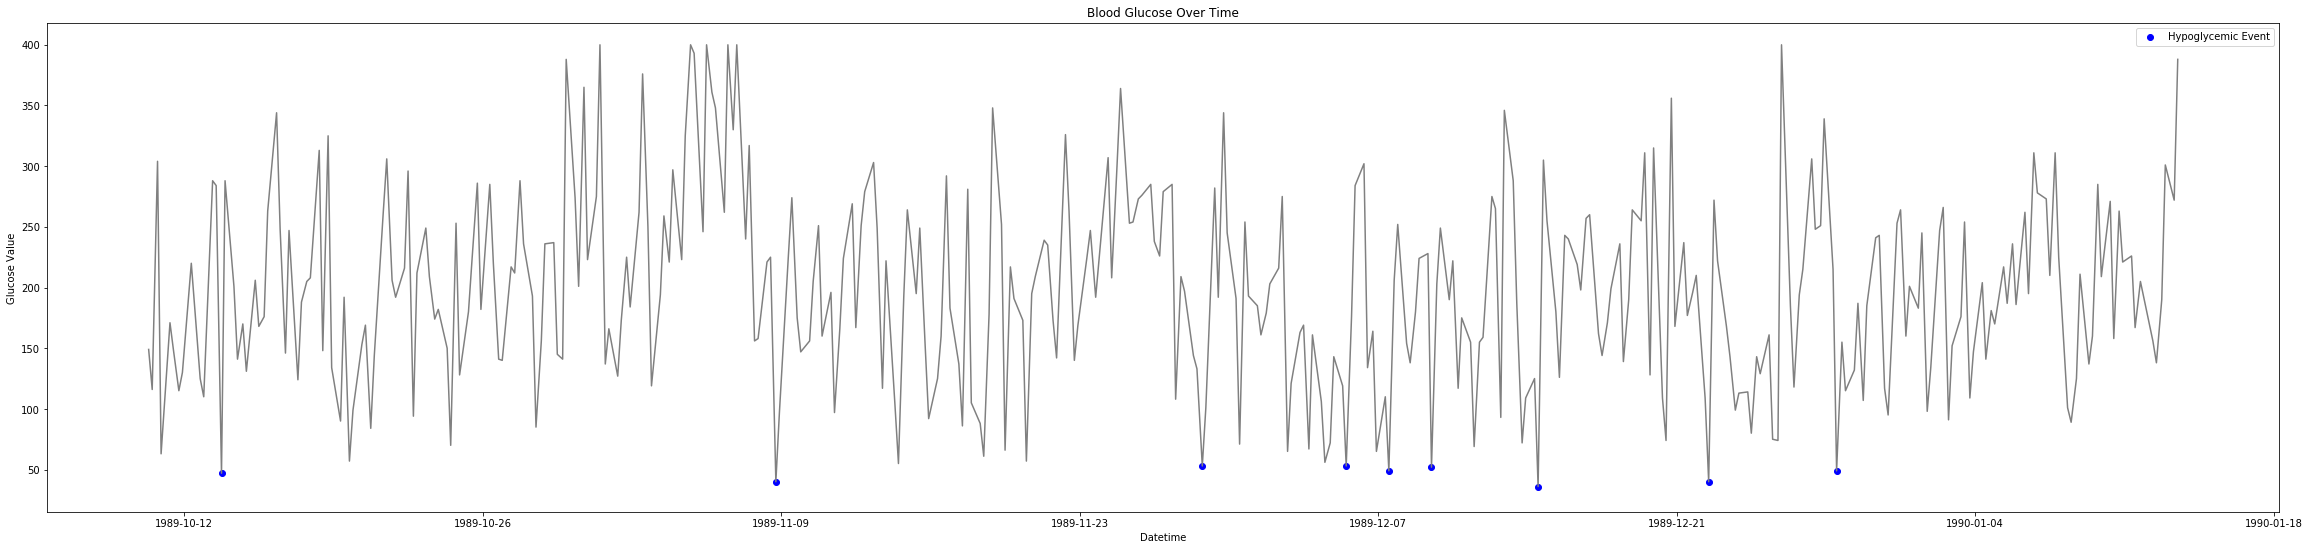

In [115]:
#Let's try a few samples 
Blood_Glucose_Chart(df2)

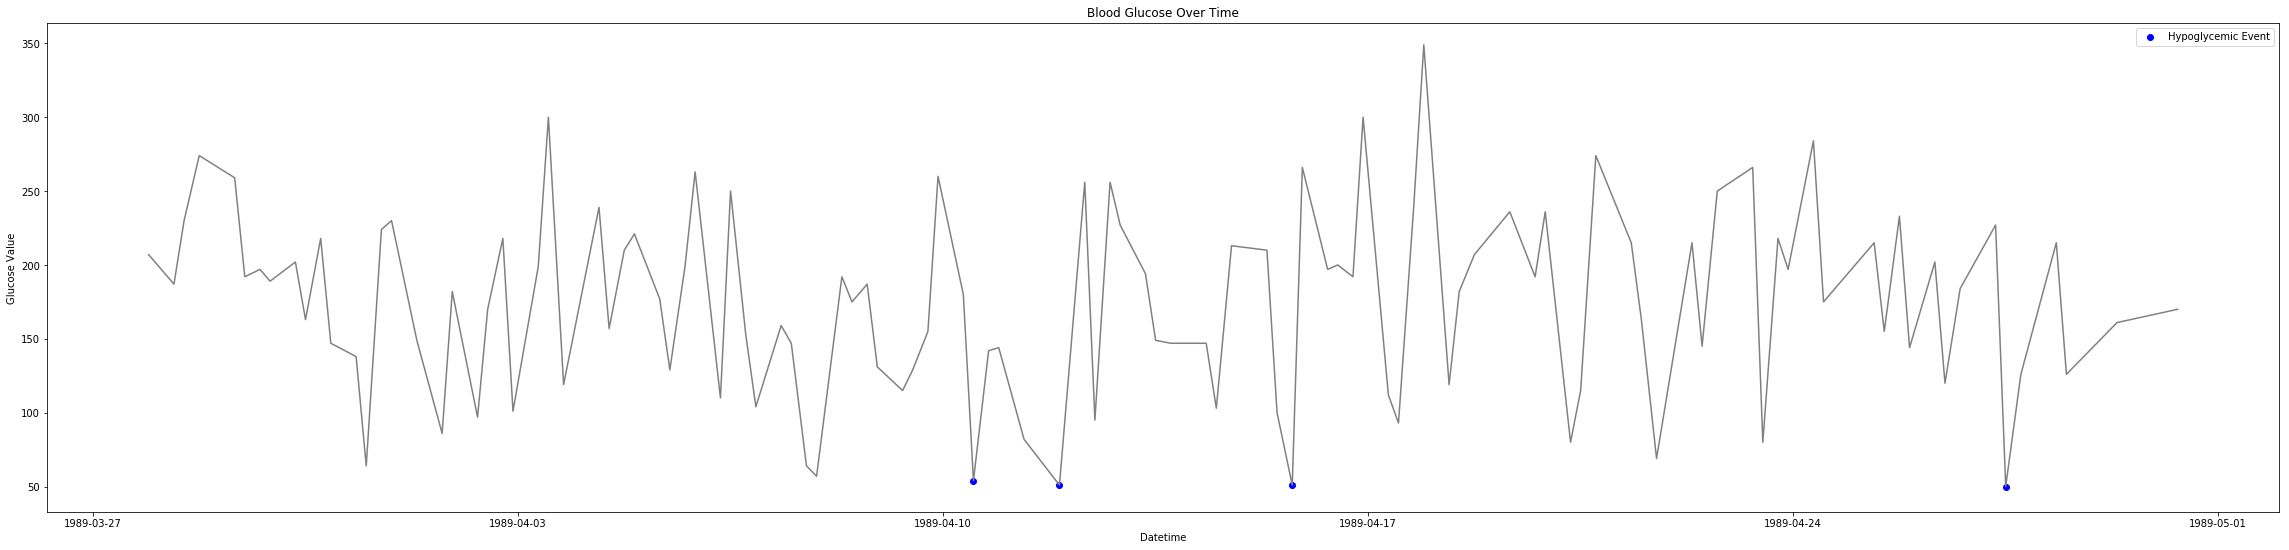

In [118]:
df7 = df_list[6]
Blood_Glucose_Chart(df7)

Now as a final exercise let's write a function to generate a Smoothed Blood Glucose Trend

In [169]:
def BloodGlucoseTrendOverTime(df):

    df_bg = df[(df['Code'] > 47) & (df['Code'] < 65)].copy()

    if df_bg.empty:
        print("No glucose records found for this patient.")
        return None
    
   #handling string values 
    df_bg['Value'] = df_bg['Value'].replace({'0Hi': '400', '0Lo': '40'})
    df_bg['Value'] = pd.to_numeric(df_bg['Value'], errors='coerce')
    df_bg = df_bg.dropna(subset=['Value'])
    df_bg['Value'] = df_bg['Value'].astype('int64')


    df_bg['Date'] = df_bg['Date'].astype(str).str.strip()
    df_bg['Time'] = df_bg['Time'].astype(str).str.strip()

# Combine and standardize format
    df_bg['datetime_str'] = df_bg['Date'] + ' ' + df_bg['Time']

# Try to parse, coercing invalid ones to NaT
    df_bg['datetime'] = pd.to_datetime(df_bg['datetime_str'], format='%m-%d-%Y %H:%M', errors='coerce')
    

    df_bg = df_bg.dropna(subset=['datetime']).sort_values('datetime')

    # setting days to zero
    #df_bg['days_since_start'] = (df_bg['datetime'] - df_bg['datetime'].min()).dt.days
    #x = df_bg['days_since_start'].values.reshape(-1, 1)
    #y = df_bg['Value'].values
    #No we are not
    #x = (df_bg.index - df_bg.index[0]).days.values
    #y = df_bg['Value'].values

    pid = df['id'].iloc[0] if 'id' in df.columns else "Unknown"
    
    df_bg['rolling_mean'] = df_bg['Value'].rolling(window=30, center=True).mean()

    plt.figure(figsize=(15,5))
    plt.plot(df_bg['datetime_str'], df_bg['Value'], alpha=0.3, label='Raw Values')
    plt.plot(df_bg['datetime_str'], df_bg['rolling_mean'], color='red', label='Rolling Mean (window=50)')
    plt.title(f"Smoothed Blood Glucose Trend for patient{pid}")
    plt.legend()
    plt.xticks(df_bg['datetime_str'][::100], rotation=0)   # every 200th label, adjust as needed
    plt.xlabel("Date")
    plt.ylabel("Blood Glucose (mg/dL)")
    plt.tight_layout()
    plt.show()

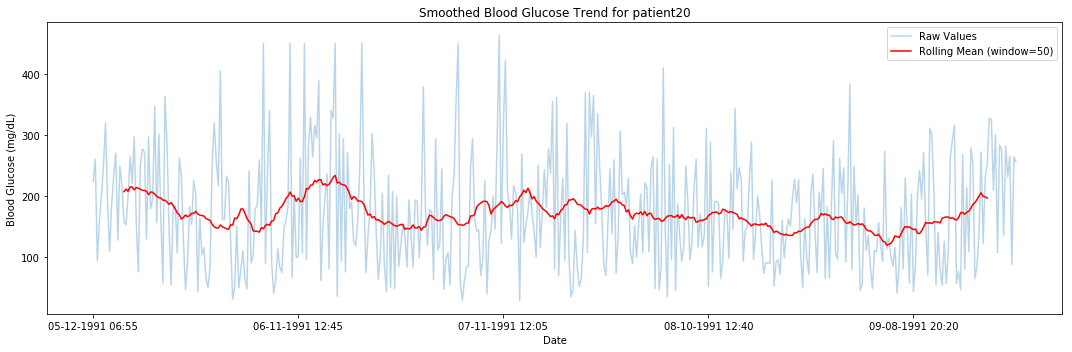

In [170]:
#Samples
BloodGlucoseTrendOverTime(df20)

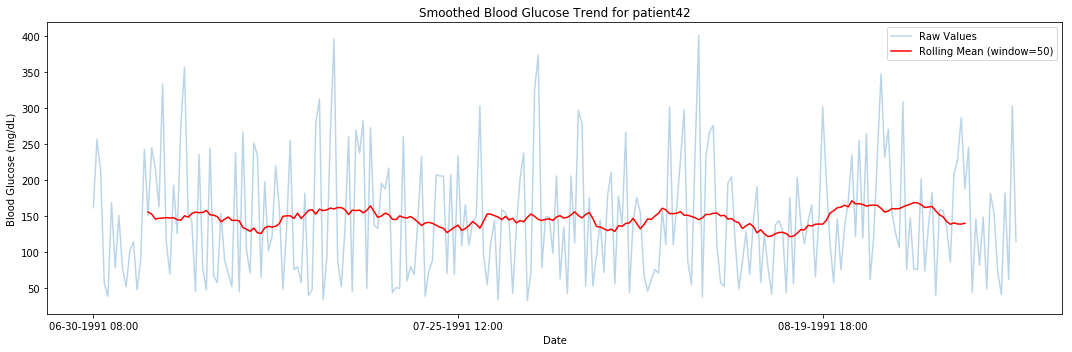

In [171]:
df42 = df_list[41]
BloodGlucoseTrendOverTime(df42)

EDA or Exploratory Data Analysis in an important step in handling any Dataset. Due to the nature of the data given, we have
managed here to separate, organize and analyze 70 different 'minisets' with concise numeric as well as visual for better 
understanding of the data.
Cheerios!